Notebook to test zero-shot prompt vs few shot prompt
Input will be Data in txt form

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Necessary libraries

In [2]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 6.0 MB/s eta 0:00:00


In [3]:
!pip install --upgrade openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.3 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.109.1
    Uninstalling openai-1.109.1:
      Successfully uninstalled openai-1.109.1


In [ ]:
import pandas as pd
import unidecode
from io import StringIO
import json
import re
import os
import openai
from openai import OpenAI
import time
import ast
from collections import defaultdict

Generate Paragraphs to feed into LLM

In [ ]:
def text_to_sentence_paragraphs(text, sentences_per_paragraph=6):
    # Basic sentence splitter
    sentences = re.split(r'(?<=[.!?])\s+', text)
    sentences = [s.strip() for s in sentences if s.strip()]
    paragraphs = []
    for i in range(0, len(sentences), sentences_per_paragraph):
        para = " ".join(sentences[i:i+sentences_per_paragraph])
        paragraphs.append(para)
    return paragraphs

def txt_file_to_page_paragraphs(txt_path, sentences_per_paragraph=6):
    """
    Reads a .txt file with "--- Page N ---" markers,
    returns a list of dicts: {"filename", "page", "paragraph"}
    """
    filename = os.path.basename(txt_path)
    with open(txt_path, "r", encoding="utf-8") as f:
        text = f.read()

    # Split by page marker
    page_blocks = re.split(r'\n?--- Page (\d+) ---\n', text)
    out = []
    # page_blocks[0] is any text before the first page (often empty)
    for i in range(1, len(page_blocks), 2):
        page_num = int(page_blocks[i])
        page_text = page_blocks[i+1]
        paragraphs = text_to_sentence_paragraphs(page_text, sentences_per_paragraph)
        for para in paragraphs:
            if para.strip():
                out.append({
                    "filename": filename,
                    "page": page_num,
                    "paragraph": para.strip()
                })
    return out

Text broken up into logical paragraphs that the LLM can process easily and simply

In [ ]:
paragraphs = txt_file_to_page_paragraphs("/content/drive/MyDrive/Data_txt/2007_Tshibubudze_THE MARKOYE FAULT_2007.txt", sentences_per_paragraph=6)
print(f"Total paragraphs: {len(paragraphs)}")
print(paragraphs[0])

Total paragraphs: 116
{'filename': '2007_Tshibubudze_THE MARKOYE FAULT_2007.txt', 'page': 6, 'paragraph': 'Abstract \nThe  regional  lithological  and  structural  mapping  completed  in  the  north-eastern  part  of \nBurkina Faso indicates that the Essakane goldfield of the West African Craton is hosted \nby  meta-volcanoclastic  and  meta-sedimentary  rocks  of  the  Birimian  sequences. The \nsequences  are  dominated  by  meta-volcanoclastic  greywackes,  intercalated  meta-\nconglomerate,  meta-sandstone-greywacke,  siltstone  and  shale. The  sequences  have \nprimary sedimentary structures preserved as compositional layering. The  depositional  environment  of  the  sequences  is  interpreted  to  have  occurred  in  a \nshallow  marine  continental  shelf  environment  at  a  delta  front  setting. The  sequences \nwhere  subjected  to  several  phases  of  deformation  and  metamorphism. They  have  been \ncontact metamorphosed to hornblende hornfels facies during emplacement

In [ ]:
!pip show openai


Name: openai
Version: 2.3.0
Summary: The official Python library for the openai API
Home-page: https://github.com/openai/openai-python
Author: 
Author-email: OpenAI <support@openai.com>
License: Apache-2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: anyio, distro, httpx, jiter, pydantic, sniffio, tqdm, typing-extensions
Required-by: 


In [ ]:
# API key
os.environ['OPENAI_API_KEY'] = ["INSERT YOUR OWN API KEY HERE"]
# Testing API connection
client = OpenAI()
try:
    model_list = client.models.list()
    print("API connection successful! Number of models:", len(model_list.data))
except Exception as e:
    print("API connection failed:", e)

API connection successful! Number of models: 93


The LLM will take in the text in paragraphs and output a csv file with the filename, extracted location, mention in paragraph and page number

Few shot Prompts

In [ ]:
#  FEW SHOT PROMPT FOR GEO LOCALITY EXTRACTION
few_shot_prompts = """
You are an assistant that extracts locality descriptions from geoscience texts.
A locality description can be:
- a site, region, province, district, city, towns, villages, or a GPS coordinate (e.g., UTM, lat/lon).
- Do NOT generate or invent localities. Only extract those *explicitly mentioned* in the paragraph.
- If there are no localities mentioned, output: []

For each paragraph, extract the *relevant locality descriptions* as a list. If none, output: None.
Example 1:
Paragraph: The NE-trending Markoye fault in Burkina Faso is a first-order crustal scale structure located in the north-eastern part of Burkina Faso
between the towns of Dori and Tambão by the border with Mali and Niger.
Localities: ["north-eastern part of Burkina Faso", "towns of Dori and Tambão", "border with Mali and Niger"]

Example 2:
Paragraph: Several east-west traverses were conducted across the Markoye fault between Essakane and Tambão. Field stations were established at
 the villages of Salmossi, Essakane, Tin Agadel, Tin Taradat, Markoye and Gorom-Gorom.
Localities: ["Markoye fault", "Essakane", "Tambão", "Salmossi", "Tin Agadel", "Tin Taradat", "Markoye", "Gorom-Gorom"]

Example 3:
Paragraph: The area of study is located ±250 km NE of the capital city, Ouagadougou, Burkina Faso (Fig. 1). The extent of the study area is
demarcated by the villages of Essakane to the south-west, Tin Agadel and Tin Taradat to the north-east, and Markoye and Gorom-Gorom to the east.
Localities: ["250 km NE of Ouagadougou, Burkina Faso", "Essakane", "Tin Agadel", "Tin Taradat", "Markoye", "Gorom-Gorom"]

Example 4:
Paragraph: The UTM coordinates of the field area are: 30 P 0805000 E, 1600000 N; 0805000 E, 1594000 N; 0810000 E, 1594000 N; 0810000 E, 1600000 N.
Localities: ["30 P 0805000 E, 1600000 N", "0805000 E, 1594000 N", "0810000 E, 1594000 N", "0810000 E, 1600000 N"]

Example 5:
Paragraph: No specific localities or coordinates are mentioned in this paragraph.
Localities: []
"""


In [ ]:
def extract_localities_llm(paragraph, model="gpt-4o"):
    prompt = (
        few_shot_prompts +
        f"\nParagraph: {paragraph}\nLocalities:"
    )
    response = openai.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        max_tokens=120,
        temperature=0,
    )
    answer = response.choices[0].message.content.strip()

    m = re.search(r"\[(.*?)\]", answer, re.DOTALL)
    if m:
        raw_list = m.group(0)
        try:
            extracted = ast.literal_eval(raw_list)
            if isinstance(extracted, str):
                extracted = [extracted]
        except:
            extracted = []
    else:
        extracted = []
    return extracted

def extract_from_paragraphs_w_page(paragraphs, model="gpt-4o"):
    if not paragraphs:
        print("No paragraphs provided.")
        return []
    print(f"\nProcessing: {paragraphs[0]['filename']} ({len(paragraphs)} paragraphs)")
    results = []
    for p in paragraphs:
        para = p['paragraph']
        page = p['page']
        filename = p['filename']
        if len(para.strip()) < 10:
            continue
        retry = 0
        while True:
            try:
                localities = extract_localities_llm(para, model=model)
                if localities:
                    results.append({
                        "filename": filename,
                        "page": page,
                        "mention": para,
                        "location": localities
                    })
                break
            except openai.RateLimitError:
                print("Rate limit hit, waiting 3 seconds...")
                time.sleep(3)
                retry += 1
                if retry > 5:
                    print("Too many retries, skipping this paragraph.")
                    break
    return results

Zero Shot Prompt

In [ ]:
ZERO_SHOT_PROMPT = """You are an assistant that extracts locality descriptions from geoscience text.

Rules:
- A "locality description" is any explicitly mentioned site, region, province, district, city, town, village,
 named geological feature (e.g., fault/belt/basin), or a coordinate string (e.g., UTM, lat/lon, degrees).
- Extract only what is explicitly in the paragraph. Do NOT infer or invent.
- Return a Python list of strings with the extracted localities. If none, return [].

Paragraph:
{paragraph}

Localities:
"""

In [ ]:
def extract_localities_zero_shot(paragraph, model="gpt-4o"):
    prompt = ZERO_SHOT_PROMPT.format(paragraph=paragraph)
    response = openai.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        max_tokens=120,
        temperature=0,
    )
    answer = response.choices[0].message.content.strip()
    m = re.search(r"\[(.*?)\]", answer, re.DOTALL)
    if m:
        raw_list = m.group(0)
        try:
            extracted = ast.literal_eval(raw_list)
            if isinstance(extracted, str):
                extracted = [extracted]
        except Exception:
            extracted = []
    else:
        extracted = []
    return extracted

In [ ]:
import unicodedata

def _normalize_loc(s: str) -> str:
    """
    Lowercase, collapse spaces, strip punctuation at ends, and normalize accents.
    Keeps commas/semicolons/degree symbols when within string (so coordinates survive),
    but trims leading/trailing punctuation/space.
    """
    if not s:
        return ""
    s = unicodedata.normalize("NFKC", s)
    s = s.strip()
    s = s.lower()
    # Collapse whitespace
    s = re.sub(r"\s+", " ", s)
    # Trim generic leading/trailing punctuation/spaces
    s = re.sub(r"^[\s,;:–—\-]+", "", s)
    s = re.sub(r"[\s,;:–—\-]+$", "", s)
    return s

def normalize_list(lst):
    return sorted({ _normalize_loc(x) for x in lst if isinstance(x, str) and _normalize_loc(x) })


In [ ]:
def extract_from_paragraphs_zero_shot(paragraphs, model="gpt-4o"):
    if not paragraphs:
        print("No paragraphs provided.")
        return []
    print(f"\nProcessing (zero-shot): {paragraphs[0]['filename']} ({len(paragraphs)} paragraphs)")
    results = []
    for p in paragraphs:
        para = p['paragraph']
        page = p['page']
        filename = p['filename']
        if len(para.strip()) < 10:
            continue
        retry = 0
        while True:
            try:
                locs = extract_localities_zero_shot(para, model=model)
                if locs:
                    results.append({
                        "filename": filename,
                        "page": page,
                        "mention": para,
                        "location": locs
                    })
                break
            except openai.RateLimitError:
                print("Rate limit hit (zero-shot), waiting 3 seconds...")
                time.sleep(3)
                retry += 1
                if retry > 5:
                    print("Too many retries (zero-shot), skipping this paragraph.")
                    break
    return results

Comparison between Zero shot and Few Shot

In [ ]:
def compare_extraction_methods(paragraphs, model_few="gpt-4o", model_zero="gpt-4o"):
    """
    paragraphs: list of dicts with keys: filename, page, paragraph
    Returns: dict with:
        - 'rows': per-paragraph comparisons
        - 'summary': aggregate metrics
    """

    # 1) Few-shot
    t0 = time.time()
    few = extract_from_paragraphs_w_page(paragraphs, model=model_few)
    few_time = time.time() - t0

    # 2) Zero-shot
    t1 = time.time()
    zero = extract_from_paragraphs_zero_shot(paragraphs, model=model_zero)
    zero_time = time.time() - t1

    # Index by (filename, page, mention) to align
    def index_results(res_list):
        idx = defaultdict(list)
        for r in res_list:
            key = (r["filename"], r["page"], r["mention"])
            idx[key].extend(r["location"])
        return idx

    few_idx = index_results(few)
    zero_idx = index_results(zero)

    rows = []
    all_keys = set(list(few_idx.keys()) + list(zero_idx.keys()))

    # For paragraphs that returned nothing in one method, we still evaluate with [].
    for p in paragraphs:
        key = (p["filename"], p["page"], p["paragraph"])
        few_raw = few_idx.get(key, [])
        zero_raw = zero_idx.get(key, [])

        few_norm = normalize_list(few_raw)
        zero_norm = normalize_list(zero_raw)

        set_few = set(few_norm)
        set_zero = set(zero_norm)
        inter = set_few.intersection(set_zero)
        union = set_few.union(set_zero)

        jaccard = (len(inter) / len(union)) if union else 1.0  # if both empty, treat as perfect agreement
        exact_match = int(set_few == set_zero)

        rows.append({
            "filename": p["filename"],
            "page": p["page"],
            "few_count": len(set_few),
            "zero_count": len(set_zero),
            "intersection": sorted(list(inter)),
            "jaccard": jaccard,
            "exact_match": exact_match,
            "few_list": sorted(list(set_few)),
            "zero_list": sorted(list(set_zero)),
            "mention": p["paragraph"][:300] + ("..." if len(p["paragraph"]) > 300 else "")
        })

    # Aggregate stats
    n = len(rows) if rows else 1
    avg_jaccard = sum(r["jaccard"] for r in rows) / n
    exact_match_rate = sum(r["exact_match"] for r in rows) / n
    avg_few = sum(r["few_count"] for r in rows) / n
    avg_zero = sum(r["zero_count"] for r in rows) / n

    # non-empty- how often each method produced at least one locality
    few_nonempty = sum(1 for r in rows if r["few_count"] > 0) / n
    zero_nonempty = sum(1 for r in rows if r["zero_count"] > 0) / n

    summary = {
        "paragraphs_evaluated": n,
        "avg_jaccard": round(avg_jaccard, 3),
        "exact_match_rate": round(exact_match_rate, 3),
        "avg_few_loc_per_para": round(avg_few, 2),
        "avg_zero_loc_per_para": round(avg_zero, 2),
        "few_nonempty_rate": round(few_nonempty, 3),
        "zero_nonempty_rate": round(zero_nonempty, 3),
        "few_runtime_sec": round(few_time, 2),
        "zero_runtime_sec": round(zero_time, 2),
    }

    return {"rows": rows, "summary": summary}


In [ ]:
import csv

def write_comparison_csv(comp, out_path="locality_extraction_comparison.csv"):
    """
    comp: result of compare_extraction_methods
    """
    rows = comp["rows"]
    with open(out_path, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow([
            "filename","page","few_count","zero_count","jaccard","exact_match",
            "intersection","few_list","zero_list","mention"
        ])
        for r in rows:
            w.writerow([
                r["filename"], r["page"], r["few_count"], r["zero_count"],
                round(r["jaccard"], 3), r["exact_match"],
                "; ".join(r["intersection"]),
                "; ".join(r["few_list"]),
                "; ".join(r["zero_list"]),
                r["mention"]
            ])
    print("Wrote:", out_path)


Extraction of Locations from a regular academic paper ( less than 100 pages)

In [ ]:
comp = compare_extraction_methods(paragraphs, model_few="gpt-4o", model_zero="gpt-4o")

# summary metrics
print("=== SUMMARY ===")
for k, v in comp["summary"].items():
    print(f"{k}: {v}")

write_comparison_csv(comp, "locality_extraction_comparison.csv")



Processing: 2007_Tshibubudze_THE MARKOYE FAULT_2007.txt (116 paragraphs)

Processing (zero-shot): 2007_Tshibubudze_THE MARKOYE FAULT_2007.txt (116 paragraphs)
=== SUMMARY ===
paragraphs_evaluated: 116
avg_jaccard: 0.676
exact_match_rate: 0.552
avg_few_loc_per_para: 1.22
avg_zero_loc_per_para: 1.75
few_nonempty_rate: 0.543
zero_nonempty_rate: 0.638
few_runtime_sec: 81.42
zero_runtime_sec: 80.06
Wrote: locality_extraction_comparison.csv


The results show that for the 2007 Markoye Fault thesis, both few-shot and zero-shot extraction performed quite well, but with clear behavioral differences. The zero-shot prompt extracted slightly more locality mentions on average (1.75 per paragraph) compared to the few-shot prompt (1.22), meaning it captured more geographic references overall. It also identified localities in 64% of paragraphs, while the few-shot approach did so in 54%. This suggests that the zero-shot method is more flexible and better at finding a wider range of place names or coordinates, giving it higher recall. However, the few-shot prompt is more conservative, following the examples strictly and likely providing cleaner, more precise results. The two methods agreed fairly well, with a Jaccard similarity of 0.68 and an exact match rate of 55%, meaning they produced identical results for about half the paragraphs. Overall, both methods are consistent and effective — the few-shot prompt prioritizes precision, while the zero-shot prompt improves coverage.

Observations of zero-shot location extraction showed that some locations were ambiguous and not exact. Thus its results will need manual checking.

Extraction from a Large research paper (Greater than 200 pages)

In [ ]:
paragraphs2 = txt_file_to_page_paragraphs("/content/drive/MyDrive/Data_txt/2015_Masurel_phd.txt", sentences_per_paragraph=6)
print(f"Total paragraphs: {len(paragraphs2)}")
print(paragraphs2[0])

Total paragraphs: 647
{'filename': '2015_Masurel_phd.txt', 'page': 2, 'paragraph': 'ii'}


In [ ]:
comp = compare_extraction_methods(paragraphs2, model_few="gpt-4o", model_zero="gpt-4o")

# summary metrics
print("=== SUMMARY ===")
for k, v in comp["summary"].items():
    print(f"{k}: {v}")

write_comparison_csv(comp, "locality_extraction_comparison.csv")


Processing: 2015_Masurel_phd.txt (647 paragraphs)

Processing (zero-shot): 2015_Masurel_phd.txt (647 paragraphs)
=== SUMMARY ===
paragraphs_evaluated: 647
avg_jaccard: 0.723
exact_match_rate: 0.626
avg_few_loc_per_para: 1.54
avg_zero_loc_per_para: 2.03
few_nonempty_rate: 0.468
zero_nonempty_rate: 0.584
few_runtime_sec: 423.89
zero_runtime_sec: 441.31
Wrote: locality_extraction_comparison.csv


For the 2015 Masurel PhD thesis, both extraction methods performed consistently across a much larger dataset of 647 paragraphs. The results show strong agreement between the few-shot and zero-shot prompts, with a high average Jaccard similarity of 0.72 and an exact match rate of 63%, meaning both approaches produced nearly identical outputs for most paragraphs. On average, the zero-shot method extracted 2.03 localities per paragraph compared to 1.54 for the few-shot prompt, indicating that zero-shot captured a broader range of place names and coordinates—reflecting higher recall. However, the few-shot approach, guided by examples, remained more conservative and more precise after manual checking.
The zero-shot method also identified at least one locality in 58% of paragraphs versus 47% for few-shot, again showing its wider coverage though some are more ambiguous.
Runtime for both methods was similar (around seven minutes each), confirming scalability for large texts. .

Visualizations

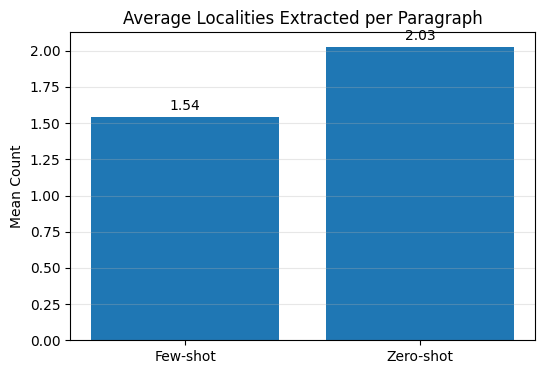

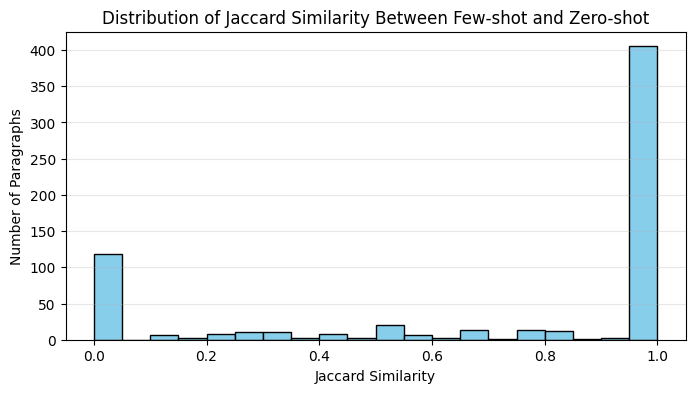

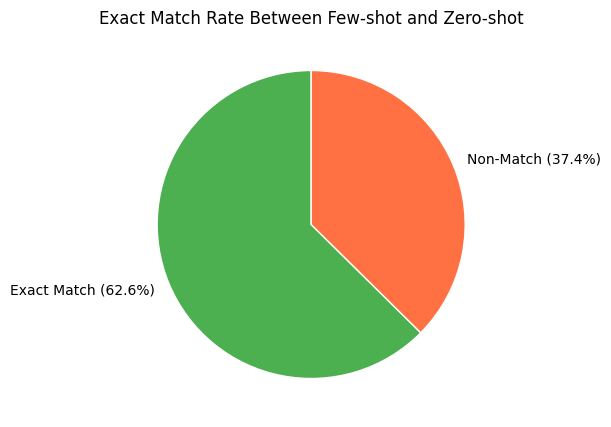

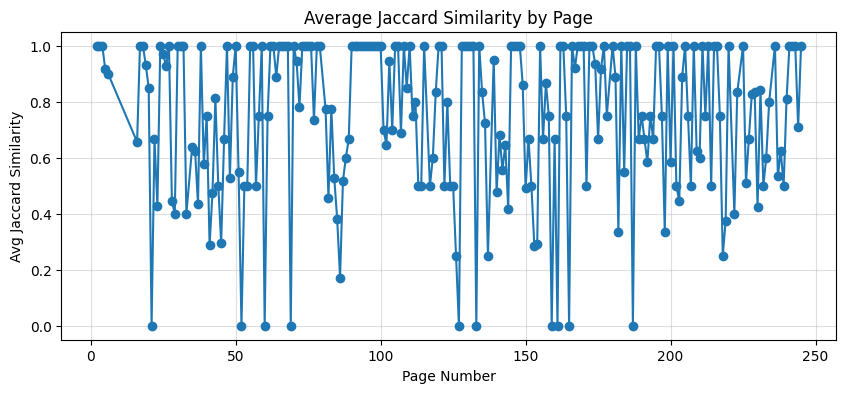

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("locality_extraction_comparison.csv")

# Average localities per paragraph
avg_few = df["few_count"].mean()
avg_zero = df["zero_count"].mean()

plt.figure(figsize=(6,4))
plt.bar(["Few-shot", "Zero-shot"], [avg_few, avg_zero])
plt.title("Average Localities Extracted per Paragraph")
plt.ylabel("Mean Count")
plt.grid(axis="y", alpha=0.3)
for i, val in enumerate([avg_few, avg_zero]):
    plt.text(i, val + 0.05, f"{val:.2f}", ha='center', fontsize=10)
plt.show()

# Distribution of Jaccard Similarity
plt.figure(figsize=(8,4))
plt.hist(df["jaccard"], bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Jaccard Similarity Between Few-shot and Zero-shot")
plt.xlabel("Jaccard Similarity")
plt.ylabel("Number of Paragraphs")
plt.grid(axis="y", alpha=0.3)
plt.show()

# Exact Match vs Non-Match
exact_rate = df["exact_match"].mean()
labels = ["Exact Match", "Non-Match"]
sizes = [exact_rate, 1 - exact_rate]
colors = ["#4CAF50", "#FF7043"]

plt.figure(figsize=(5,5))
plt.pie(sizes, labels=[f"{labels[0]} ({sizes[0]*100:.1f}%)", f"{labels[1]} ({sizes[1]*100:.1f}%)"],
        autopct="", startangle=90, colors=colors, wedgeprops={"edgecolor": "white"})
plt.title("Exact Match Rate Between Few-shot and Zero-shot")
plt.show()

